# Trabajo Práctico N° 3

El objetivo de este trabajo práctico es implementar modelos de regresión categórica que nos permita resolver problemas de clasificación.

Para ello utilizaremos un dataset "propio", es decir, fue seleccionado por los integrantes de nuestro.

El dataset elegido fue una base de datos de estudios de Resonancia Magnética correspondiente a clientes de la empresa Canon Medical Systems Argentina.

Estos datos describen los estudios realizados por el resonador magnético indicando distintas características del mismo como:

- Fecha/Hora
- Duración
- Región Anatómica a la que corresponde
- Bobina de Radiofrecuencia Utilizada
- Tiempo de Respuesta (RT)
- TIempo de Eco (TE)
- Campo de Visión (FOV)

La variable target elegida es la de **Región Anatómica**.

La lógica implentada es que según la región del cuerpo que se quiere estudiar (cabeza, tórax, muñeca, rodilla) van a variar distintos parámetros correspondientes al estudio como: tiempo de duración del mismo, tipo de bobina utilizado, campo de visión, plano de reconstrucción, tamaño de píxeles de la matriz de reconstrucción, etc.


## 0- Importación de Librerias 

In [1]:
#Importacion de librerias/módulos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
pd.set_option("display.max_columns", None)


## 1- Lectura/Análisis Inicial de los datos

### Leemos el dataset de un archivo .csv

In [2]:
#Establezco la dirección del archivo
file_location="datos_TP3.csv"

#Leo el data set usando la librería pandas
# y se almacena en el objeto Dataframe llamado datos_crudos  
datos_crudos=pd.read_csv(file_location, index_col=0)


#datos_crudos=datos_crudos.sample(30000, random_state=1)

#limito los datos a un único cliente
datos_crudos=datos_crudos.loc[datos_crudos['Site_ID']==8633]

### Visualizamos los primeros registros del mismo. Desplegando todas las columnas

In [3]:
#Configuramos para que muestre todas las columnas
pd.set_option('display.max_columns', None)

datos_crudos.sample(10)

,Study,No,Start,Scan ID,Mode,Scan Comment,Anatomy,PatientOrient,RcCoil,TxCoil,ContrastName,Plane,Sequence,Option,ScanMode,Time,TR,TE,FA,NS,ST,Gap,FOV,MTX,NAQ,BW,NoWrap,Options,Fltr,Gate,Coverages,Dynamic,SORS,FAT,MTC,Date,Site_ID,Site Name
117518,40978.838,7,10:43,AX T1WI FatSAT,(A),AX T1WI FatSAT,Pelvis,H:S,BODY,WB,NaN,AX:RL,FSE2D+10,NaN,(A),03:09,638,10,90/160,30,5.0,1.0,27.0,192 x 352,1.0,195,PE,NaN,GA54,NaN,3,OFF,NaN,ON,OFF,2022-08-19,8633,Sanatorio Juncal
142142,43086.838,16,08:14,Shimming,(A),iAAS_Head_HEAD,Head,F:S,OHD-A,WB,NaN,AX:AP,FE_AAS,AAS,(A),00:13,200,4.8/9.6,70,15,5.0,9.7,20.0,64,1.0,488,NaN,AAS,NONE,NaN,1,OFF,NaN,OFF,OFF,2022-11-10,8633,Sanatorio Juncal
112813,40559.838,6,13:18,CO T2WI,(A),T2WI,Head,H:S,OHD-A,WB,NaN,Oth:AXp,FSE2D+10,NaN,(A),01:01,4057,100,90/160,20,6.0,1.2,23.0,256 x 352,1.0,195,NaN,NaN,GA42,NaN,1,OFF,NaN,OFF,OFF,2022-08-05,8633,Sanatorio Juncal
119323,41141.838,8,10:43,AX Body DWI (B,(AB),Body DWI,Abdomen,H:S,BODY,WB,NaN,AX:AP,SE_EPI90+0.8_trape,ets0.8,(AB),00:44,2393,90,90/160,30,5.0,1.0,35.0 x 40.0,112,1.0,1302,NaN,ets0.8,NL2,NaN,2,OFF,NaN,OFF,OFF,2022-08-24,8633,Sanatorio Juncal
139183,42823.838,20,13:06,MAP,(AC),iMAP_CSpine,C-Spine,H:S,OHD-A,WB,NaN,AX:AP,FE_map,MAP,(AC),00:24,180,4,20,20,6.0,16.3,43.0 x 50.0,64,1.0,488,RO,MAP,L1,NaN,1,OFF,NaN,OFF,OFF,2022-11-01,8633,Sanatorio Juncal
140072,42903.838,2,19:26,SG T2WI STIR,(A),T2WI STIR,TL-Spine,H:S,OSP-A,WB,NaN,Oth:COp,FSE2D+7.5,NaN,(A),01:55,5000,105,90/180,14,4.0,0.8,35.0 x 23.7,160 x 256,2.0,326,PE,NaN,GA54,NaN,1,OFF,NaN,OFF,OFF,2022-11-03,8633,Sanatorio Juncal
128629,41913.838,3,16:00,AX FLAIR,(A),FLAIR,Head,H:S,OHD-A,WB,NaN,Oth:Oth,FSE2D+10,NaN,(A),03:00,10000,120,90/180,20,6.0,1.2,23.0 x 23.0,192 x 272,2.0,195,NaN,NaN,GA42,NaN,2,OFF,NaN,OFF,OFF,2022-09-30,8633,Sanatorio Juncal
128043,41867.838,4,22:50,SG PDWI TE33,(A),SG PDWI TE33 IZQ,Extremity,F:S,0x47410069,WB,NaN,Oth:Oth,FSE2D+11,NaN,(A),01:52,2729,33,90/180,22,3.5,1.0,16.0,256 x 352,1.0,244,PE,NaN,GA42,NaN,1,OFF,NaN,OFF,OFF,2022-09-28,8633,Sanatorio Juncal
140292,42922.838,12,13:03,CO T2WI,(A),T2WI,Head,H:S,OHD-A,WB,NaN,Oth:Oth,FSE2D+15,NaN,(A),02:23,2696,90,90/160,15,3.0,0.6,18.0,192 x 256,2.0,122,PE/RO,NaN,GA42,NaN,1,OFF,NaN,OFF,OFF,2022-11-04,8633,Sanatorio Juncal
122997,41439.838,5,08:55,AX T1WI,(A),T1WI,Head,H:S,OHD-A,WB,NaN,Oth:Oth,SE15_opt,OPT,(A),01:36,537,15,70/180,20,6.0,1.2,23.0 x 23.0,176 x 320,1.0,122,NaN,OPT,GA42,NaN,1,OFF,NaN,OFF,OFF,2022-09-14,8633,Sanatorio Juncal


## Descripción de Columnas de Interes:

- PatientOrient: Orientación del paciente dentro del gantry.
- RcCoil: Bobina de Radiofrecuencia.  
- TxCoil: Bobina de Transmisión.
- Plane: Plano del estudio.
- Sequence: Tipo de secuencia del estudio.
- Time: Tiempo de duración en minutos de la secuencia.
- TR(Repetition Time): Tiempo entre secuencias de excitación.
- TE(Echo Time): Tiempo entre excitación de campo y señal de RM.
- FA (Flip Angle): Ángulo formado por el vector spin y el plano X-Y.
- NS
- ST (Slice Thickness): Grosor axial de la imagen adquiridad.
- Gap
- FOV (Field of View): Campo de Visión, tamaño de porción anatómica que visualizaco(cm x cm)
- MTX (Matrix): Matriz de reconstrucción de la imagen (pixel x pixel). Resolución espacial.
- NAQ (Number of Adquisitions): Número de adquisiciones en una secuencia dada.


# 2- Limpieza de Datos
### Verificamos la calidad de columnas en cuanto valores nulos

In [4]:
#Ordenando de mayor a menor por porcentaje de valores nulos en cada columna
datos_crudos.isna().sum().sort_values(ascending=False)/datos_crudos.shape[0]*100

Gate             99.688999
SORS             99.685691
ContrastName     96.221671
Options          45.114971
Option           45.114971
NoWrap           44.449959
Scan Comment     18.378825
ScanMode          8.588916
Mode              8.588916
Gap               2.488007
MTX               0.000000
NAQ               0.000000
BW                0.000000
Fltr              0.000000
Study             0.000000
FOV               0.000000
Dynamic           0.000000
FAT               0.000000
MTC               0.000000
Date              0.000000
Site_ID           0.000000
Coverages         0.000000
NS                0.000000
ST                0.000000
No                0.000000
FA                0.000000
TE                0.000000
TR                0.000000
Time              0.000000
Sequence          0.000000
Plane             0.000000
TxCoil            0.000000
RcCoil            0.000000
PatientOrient     0.000000
Anatomy           0.000000
Scan ID           0.000000
Start             0.000000
S

### Realizamos limpieza de algunas columnas que podrían ser numéricas en vez de objetos

In [5]:
# Paso el campo Time con formato 00:00 a segundos
datos_crudos['Time'] = datos_crudos.Time.str.split(pat=':', expand=True)[0].astype(int)*60+\
                                datos_crudos.Time.str.split(pat=':', expand=True)[1].astype(int)

In [6]:
datos_crudos['TE'] = datos_crudos.TE.str.split(pat='/', expand=True)[0].astype(float)

In [7]:
datos_crudos['FA'] = datos_crudos.FA.str.split(pat='/', expand=True)[0].astype(int)

In [8]:
datos_crudos['FOV_1'] = datos_crudos.FOV.str.split(pat=' x ', expand=True)[0].astype(float)
datos_crudos['FOV_2'] = datos_crudos.FOV.str.split(pat=' x ', expand=True)[1].astype(float)

datos_crudos['FOV_2'] = datos_crudos.apply(lambda x: x['FOV_2'] if x['FOV_2'] > 0 else x['FOV_1'], axis=1)

In [9]:
datos_crudos['MTX_1'] = datos_crudos.MTX.str.split(pat=' x ', expand=True)[0].astype(int)
datos_crudos['MTX_2'] = datos_crudos.MTX.str.split(pat=' x ', expand=True)[1].astype(float)

In [10]:
datos_crudos['MTX_2'] = datos_crudos.apply(lambda x: x['MTX_2'] if x['MTX_2'] > 0 else x['MTX_1'], axis=1)
datos_crudos['MTX_2'] = datos_crudos['MTX_2'].astype(int)

### Removemos aquellas columnas que son redundantes y/o tiene altos valores de porcentajes nulos

In [11]:
# Drop Columnas redundantes y que tienen gran cantidad de Nans
datos=datos_crudos.drop(columns=["SORS", "Gate", "ContrastName", "Options", "Option", "NoWrap", "Site_ID", "Date","Site Name"])

### Ahora damos de la baja las filas donde haya valores nulos

In [12]:
# Drop filas con Nans restantes
datos.dropna(axis=0, inplace=True)

### Verificamos las posibles categorías de la variable target "Región Anatómica"

In [13]:
datos.Anatomy.value_counts(normalize=True)*100

Head         30.650817
Extremity    25.237321
TL-Spine     16.077995
Pelvis        9.497135
Abdomen       6.636449
C-Spine       5.144103
Shoulder      5.028650
Hand          0.949286
Chest         0.611477
Ankle         0.166766
Name: Anatomy, dtype: float64

In [14]:
# Elimino las filas con target "???""
datos = datos[datos['Anatomy'] != "???"]

## 3-Implementación de Modelos

### Definimos la matriz de features y el vector target

### No incluimos dentro la matriz de features algunas columnas que tienen una relación 1 a 1 con el vector target.

Es el caso de las bobinas de Señal y de Radiofrecuencia.

In [14]:
#Matriz de Features
X = datos[['PatientOrient','Plane','Sequence','Time','TR','TE','FA','NS','ST','Gap','FOV','MTX','NAQ']]

#Vector Target
y = datos.Anatomy



In [18]:
categorical = X.select_dtypes("object").columns

### Separamos los datos en Train y Test

In [15]:
#Train y split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

### Implementamos Dummies para las variables categóricas

In [16]:
from sklearn.preprocessing import OneHotEncoder 

def dummies_categoricas(categorias, dataframe1, dataframe2):    
        onehot = OneHotEncoder(drop = "first", handle_unknown='ignore')        
        X_enc_fit= onehot.fit_transform(dataframe1).toarray()
        X_enc_trans= onehot.transform(dataframe2).toarray()        
        enc_data_fit = pd.DataFrame(X_enc_fit, columns = onehot.get_feature_names_out())
        enc_data_trans = pd.DataFrame(X_enc_trans, columns = onehot.get_feature_names_out())
        dataframe1 = pd.concat([dataframe1.drop(columns=categorias).reset_index(drop=True), enc_data_fit], axis=1)
        dataframe2 = pd.concat([dataframe2.drop(columns=categorias).reset_index(drop=True), enc_data_trans], axis=1)
        return dataframe1, dataframe2  

In [19]:
X_train, X_test = dummies_categoricas(categorical, X_train, X_test)

c:\Users\fpeloso\Anaconda3\envs\DH\lib\site-packages\sklearn\preprocessing\_encoders.py:182: UserWarning: Found unknown categories in columns [1, 3, 4, 7, 8, 9, 10, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


###  Escalamos


In [20]:
# Scalar
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
X_train_scaler = scaler.fit_transform(X_train)
X_test_scaler= scaler.transform(X_test)

In [21]:
print(f"Size pre-PCA: {X_train_scaler.shape}")

Size pre-PCA: (18708, 3106)


In [22]:
#Guardo los valores previos la uso de PCA
X_train_scaler_sinPCA=X_train_scaler
X_test_scaler_sinPCA=X_test_scaler

### Usamos PCA (Principal Component Analysis)

Es una técnica de extracción de características donde combinamos las entradas de una manera específica y podemos eliminar algunas de las variables “menos importantes” manteniendo la parte más importante todas las variables. Como valor añadido, luego de aplicar PCA conseguiremos que todas las nuevas variables sean independientes una de otra.


Decidimos utilizar esta tecnica para disminuir las variables ya que luego de realizar dummies obtenemos un total de mas de 3000 columnas lo que hace difilcutoso la realizacion de los modelos. Mediante este procedimiento se logra reducir las variables y logrando un mejor rendimiento de los modelos.

In [22]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.80)
X_train_scaler = pca.fit_transform(X_train_scaler)
X_test_scaler = pca.transform(X_test_scaler)


In [23]:
print("Número de componentes:", pca.n_components_)


Número de componentes: 1748


In [24]:
print(f"Size post-PCA: {X_train_scaler.shape}")

Size post-PCA: (18708, 1748)


### Definimos una función que evalue los modelos aplicando distintas métricas:

In [25]:
# Funcion para Scores

resultados_fin = pd.DataFrame()

def evaluacion(y_test, y_pred, model=""):
    # Crear diccionario para almacenar los resultados
    resultados = {}

    # Calcular sensibilidad
    sensibilidad = metrics.recall_score(y_test, y_pred, average='macro')
    resultados['Sensibilidad'] = round(sensibilidad,2)

    # Calcular accuracy
    accuracy = metrics.accuracy_score(y_test, y_pred)
    resultados['Accuracy'] = round(accuracy,2)

    # Calcular precision
    precision = metrics.precision_score(y_test, y_pred, average='macro')
    resultados['Precision'] = round(precision,2)

    # Calcular F1 score
    f1_score = metrics.f1_score(y_test, y_pred, average='macro')
    resultados['F1 Score'] = round(f1_score,2)

    # Graficar matrix de confusion con heatmap
    cm = metrics.confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=np.unique(y_test).tolist(), yticklabels=np.unique(y_pred).tolist())
    plt.title(f'Matrix de Confusion {model}')
    plt.ylabel('Valor Real')
    plt.xlabel('Valor Predicho')
    plt.show()

    resultado_df = pd.DataFrame.from_dict(resultados, orient='index', columns=[model])
    resultados_fin[model]= resultado_df 
    return resultados_fin.transpose().reset_index().rename(columns={"index": "Modelos"})

## 3.1 - Regresión Logística

In [26]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=2000, random_state=1)

lr.fit(X_train_scaler, y_train) 

ypred_lr_train = lr.predict(X_train_scaler)
ypred_lr_test = lr.predict(X_test_scaler)


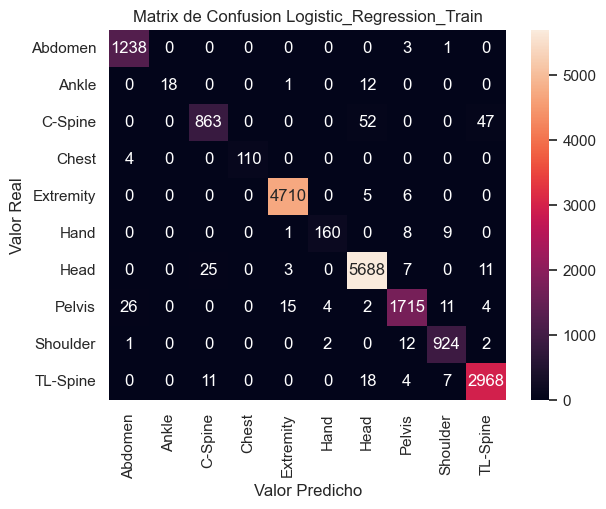

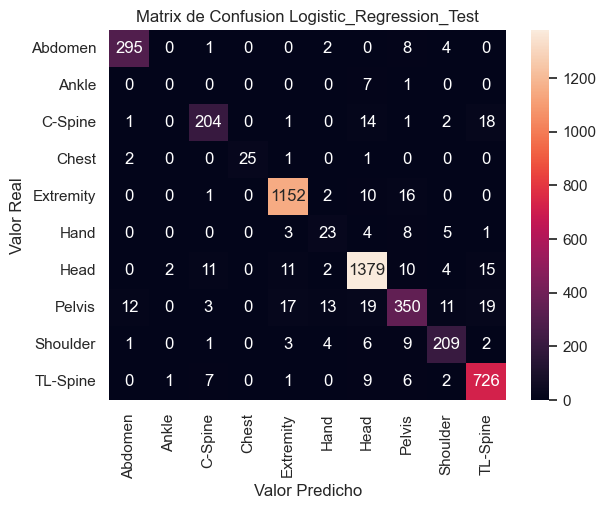

,Modelos,Sensibilidad,Accuracy,Precision,F1 Score
0,Logistic_Regression_Train,0.93,0.98,0.98,0.95
1,Logistic_Regression_Test,0.78,0.93,0.79,0.78


In [27]:
evaluacion(y_train, ypred_lr_train, model="Logistic_Regression_Train")


evaluacion(y_test, ypred_lr_test, model="Logistic_Regression_Test")


## 3.2 - Naive Bayes

In [28]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()

gnb.fit(X_train_scaler, y_train)


ypred_gnb_train = gnb.predict(X_train_scaler)


ypred_gnb_test = gnb.predict(X_test_scaler)

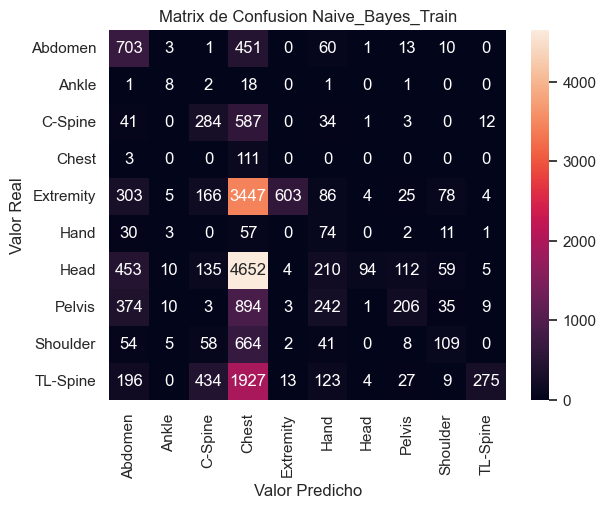

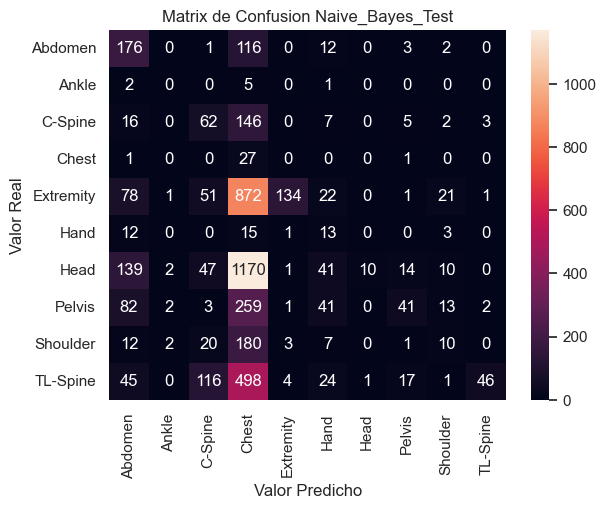

,Modelos,Sensibilidad,Accuracy,Precision,F1 Score
0,Logistic_Regression_Train,0.93,0.98,0.98,0.95
1,Logistic_Regression_Test,0.78,0.93,0.79,0.78
2,Naive_Bayes_Train,0.30,0.13,0.45,0.19
3,Naive_Bayes_Test,0.24,0.11,0.40,0.13


In [29]:

evaluacion(y_train, ypred_gnb_train, model="Naive_Bayes_Train")


evaluacion(y_test, ypred_gnb_test, model="Naive_Bayes_Test")

## 3.3 -KNN


In [30]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

# Hyperparametros
parameters_knn = {"n_neighbors" : list(range(1, 15))}

clf_knn = GridSearchCV(knn, 
                   param_grid = parameters_knn, 
                   refit = True, 
                   cv = 3,
                   verbose=1,
                   n_jobs = -1)
                   

# Fit el modelo ya seleccionado
clf_knn.fit(X_train_scaler, y_train)

Fitting 3 folds for each of 14 candidates, totalling 42 fits


GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14]},
             verbose=1)

In [31]:
print("Los mejores parametros fueron %s con un score de %0.2f" % (clf_knn.best_params_, clf_knn.best_score_))

Los mejores parametros fueron {'n_neighbors': 1} con un score de 0.89


In [32]:
ypred_knn_train = clf_knn.predict(X_train_scaler)
ypred_knn_test = clf_knn.predict(X_test_scaler)

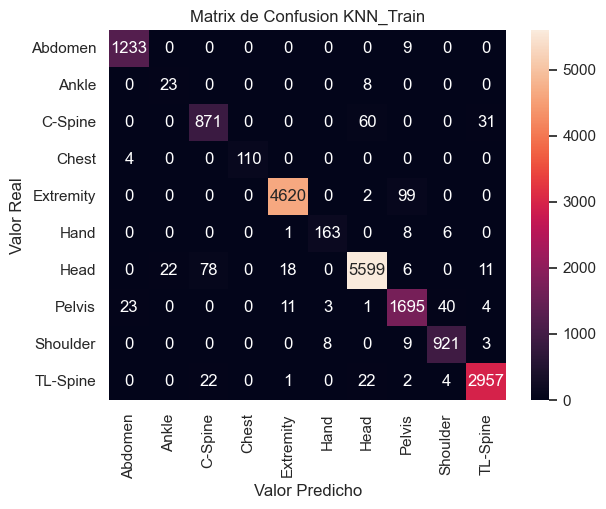

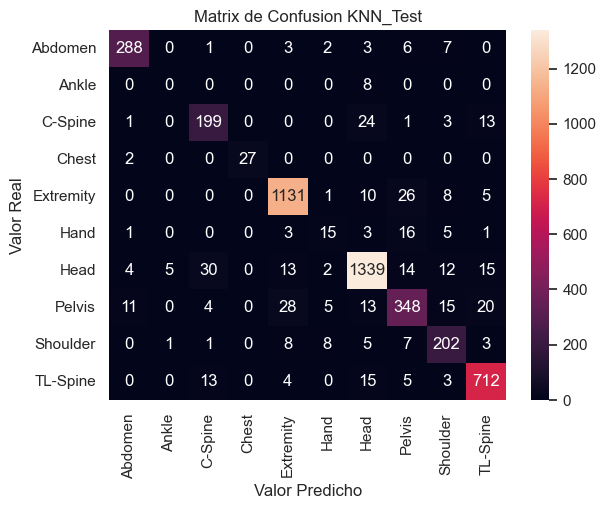

,Modelos,Sensibilidad,Accuracy,Precision,F1 Score
0,Logistic_Regression_Train,0.93,0.98,0.98,0.95
1,Logistic_Regression_Test,0.78,0.93,0.79,0.78
2,Naive_Bayes_Train,0.30,0.13,0.45,0.19
3,Naive_Bayes_Test,0.24,0.11,0.40,0.13
4,KNN_Train,0.94,0.97,0.92,0.93
5,KNN_Test,0.75,0.91,0.76,0.76


In [33]:

evaluacion(y_train, ypred_knn_train, model="KNN_Train")


evaluacion(y_test, ypred_knn_test, model="KNN_Test")

## 3.4 - Visualizacion y Comparativa de Modelos


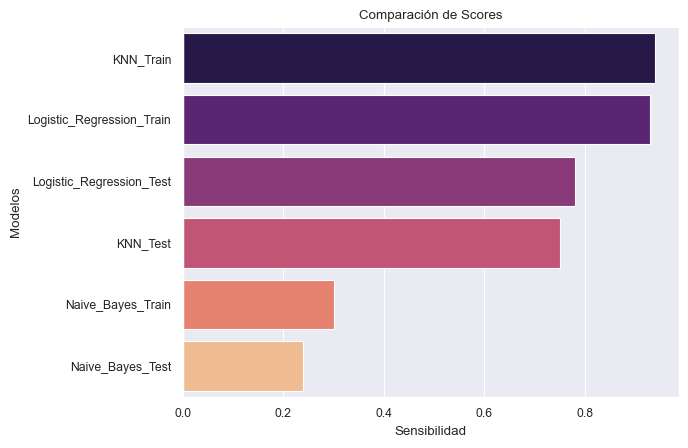

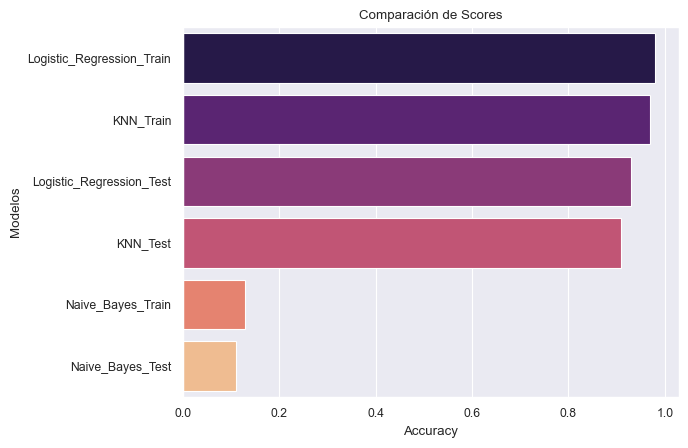

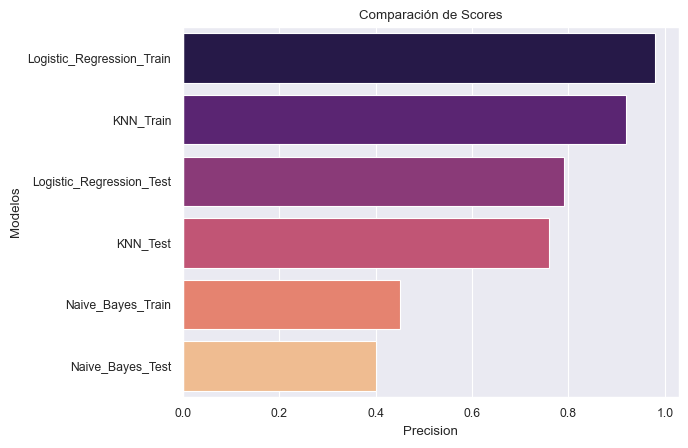

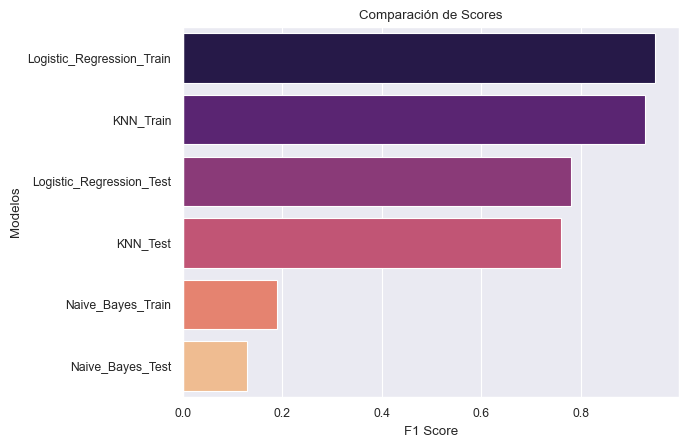

In [34]:
resultados_fin = resultados_fin.transpose().reset_index().rename(columns={"index": "Modelos"})
scores_columns= ["Sensibilidad","Accuracy", "Precision", "F1 Score"]

for scores in scores_columns:
    sns.set_context('paper')
    ax = sns.barplot(x =resultados_fin[scores] ,y = "Modelos" ,data = resultados_fin.sort_values(by=scores, ascending=False), palette = 'magma')
    ax.set(xlabel=scores, ylabel="Modelos", title="Comparación de Scores")
    plt.show()

# 4- Implementación de Modelos sin usar PCA

In [23]:
# Funcion para Scores

resultados_fin_sinPCA = pd.DataFrame()

def evaluacion_sinPCA(y_test, y_pred, model=""):
    # Crear diccionario para almacenar los resultados
    resultados = {}

    # Calcular sensibilidad
    sensibilidad = metrics.recall_score(y_test, y_pred, average='macro')
    resultados['Sensibilidad'] = round(sensibilidad,2)

    # Calcular accuracy
    accuracy = metrics.accuracy_score(y_test, y_pred)
    resultados['Accuracy'] = round(accuracy,2)

    # Calcular precision
    precision = metrics.precision_score(y_test, y_pred, average='macro')
    resultados['Precision'] = round(precision,2)

    # Calcular F1 score
    f1_score = metrics.f1_score(y_test, y_pred, average='macro')
    resultados['F1 Score'] = round(f1_score,2)

    # Graficar matrix de confusion con heatmap
    cm = metrics.confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=np.unique(y_test).tolist(), yticklabels=np.unique(y_pred).tolist())
    plt.title(f'Matrix de Confusion {model}')
    plt.ylabel('Valor Real')
    plt.xlabel('Valor Predicho')
    plt.show()

    resultado_df = pd.DataFrame.from_dict(resultados, orient='index', columns=[model])
    resultados_fin_sinPCA[model]= resultado_df 
    return resultados_fin_sinPCA.transpose().reset_index().rename(columns={"index": "Modelos"})

# 4.1 - Regresión Logística

In [24]:
from sklearn.linear_model import LogisticRegression

lr_sinPCA = LogisticRegression(max_iter=2000, random_state=1)

lr_sinPCA.fit(X_train_scaler_sinPCA, y_train) 

ypred_lr_train_sinPCA = lr_sinPCA.predict(X_train_scaler_sinPCA)
ypred_lr_test_sinPCA = lr_sinPCA.predict(X_test_scaler_sinPCA)


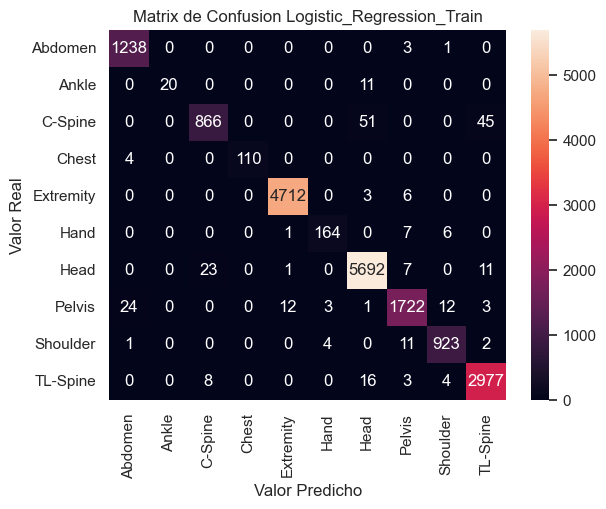

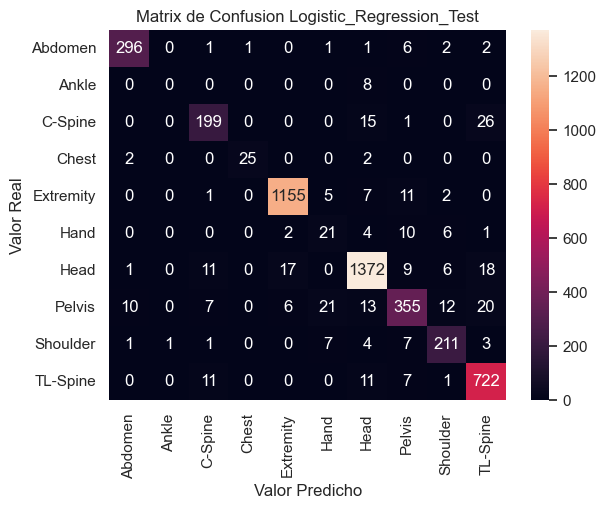

,Modelos,Sensibilidad,Accuracy,Precision,F1 Score
0,Logistic_Regression_Train,0.94,0.98,0.98,0.95
1,Logistic_Regression_Test,0.77,0.93,0.78,0.77


In [25]:
evaluacion_sinPCA(y_train, ypred_lr_train_sinPCA, model="Logistic_Regression_Train")


evaluacion_sinPCA(y_test, ypred_lr_test_sinPCA, model="Logistic_Regression_Test")

# 4.2 Naive Bayes sin PCA

In [26]:
from sklearn.naive_bayes import GaussianNB

gnb_sinPCA = GaussianNB()

gnb_sinPCA.fit(X_train_scaler_sinPCA, y_train)


ypred_gnb_train_sinPCA = gnb_sinPCA.predict(X_train_scaler_sinPCA)


ypred_gnb_test_sinPCA = gnb_sinPCA.predict(X_test_scaler_sinPCA)

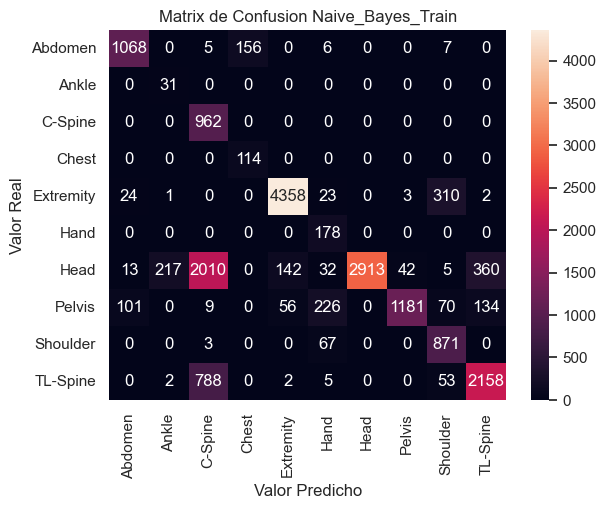

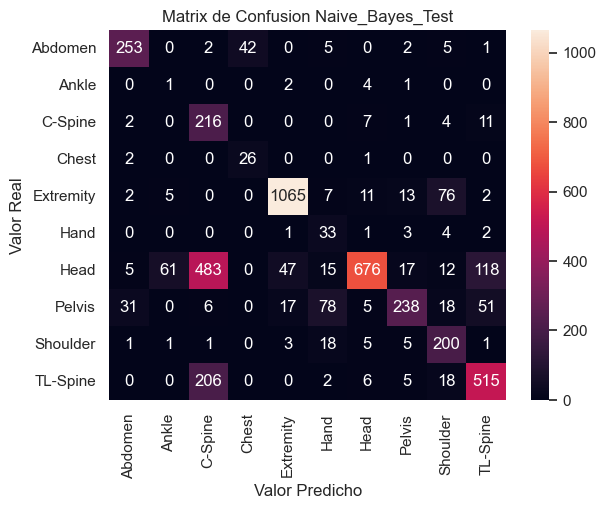

,Modelos,Sensibilidad,Accuracy,Precision,F1 Score
0,Logistic_Regression_Train,0.94,0.98,0.98,0.95
1,Logistic_Regression_Test,0.77,0.93,0.78,0.77
2,Naive_Bayes_Train,0.86,0.74,0.64,0.65
3,Naive_Bayes_Test,0.69,0.69,0.57,0.57


In [27]:
evaluacion_sinPCA(y_train, ypred_gnb_train_sinPCA, model="Naive_Bayes_Train")


evaluacion_sinPCA(y_test, ypred_gnb_test_sinPCA, model="Naive_Bayes_Test")

## 4.3 KNN sin PCA

In [28]:
from sklearn.neighbors import KNeighborsClassifier

knn_sinPCA = KNeighborsClassifier()

# Hyperparametros
parameters_knn = {"n_neighbors" : list(range(1, 15))}

clf_knn_sinPCA = GridSearchCV(knn_sinPCA, 
                   param_grid = parameters_knn, 
                   refit = True, 
                   cv = 3,
                   verbose=1,
                   n_jobs = -1)
                   

# Fit el modelo ya seleccionado
clf_knn_sinPCA.fit(X_train_scaler_sinPCA, y_train)

Fitting 3 folds for each of 14 candidates, totalling 42 fits


GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14]},
             verbose=1)

In [29]:
print("Los mejores parametros fueron %s con un score de %0.2f" % (clf_knn_sinPCA.best_params_, clf_knn_sinPCA.best_score_))

Los mejores parametros fueron {'n_neighbors': 1} con un score de 0.89


In [30]:
ypred_knn_train_sinPCA = clf_knn_sinPCA.predict(X_train_scaler_sinPCA)
ypred_knn_test_sinPCA = clf_knn_sinPCA.predict(X_test_scaler_sinPCA)

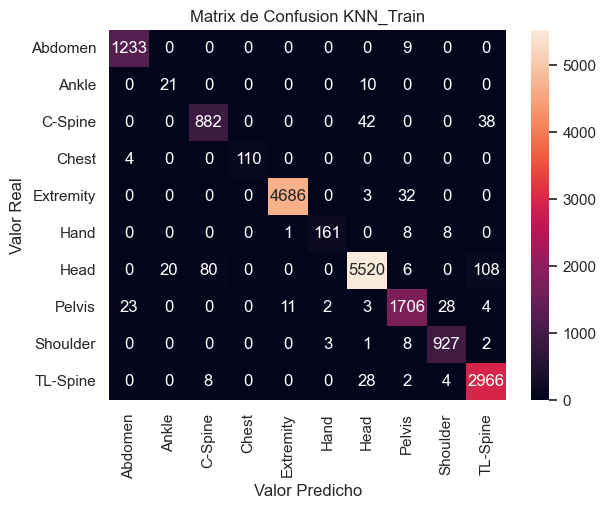

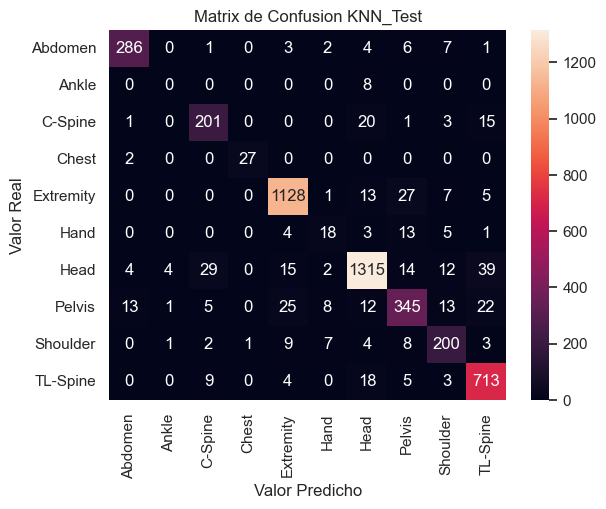

,Modelos,Sensibilidad,Accuracy,Precision,F1 Score
0,Logistic_Regression_Train,0.94,0.98,0.98,0.95
1,Logistic_Regression_Test,0.77,0.93,0.78,0.77
2,Naive_Bayes_Train,0.86,0.74,0.64,0.65
3,Naive_Bayes_Test,0.69,0.69,0.57,0.57
4,KNN_Train,0.93,0.97,0.92,0.93
5,KNN_Test,0.75,0.90,0.76,0.76


In [31]:

evaluacion_sinPCA(y_train, ypred_knn_train_sinPCA, model="KNN_Train")


evaluacion_sinPCA(y_test, ypred_knn_test_sinPCA, model="KNN_Test")